In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ModuleNotFoundError:
    print("Installing seaborn")
    !pip install seaborn
    import seaborn as sns

input_dir = os.path.join(os.path.dirname((os.path.abspath(""))), 'data') 
df = pd.read_csv(os.path.join(input_dir, 'training_data.csv'))


### Checking basic statistics for all columns
#### Numeric: Summary statistics, histograms
#### String: Unique values, % occurences

                step        amount  oldbalanceOrig  newbalanceOrig  \
count  800000.000000  8.000000e+05    8.000000e+05    8.000000e+05   
mean      243.446689  1.798341e+05    8.279412e+05    8.491754e+05   
std       142.456480  6.142608e+05    2.879656e+06    2.915518e+06   
min         1.000000  0.000000e+00    0.000000e+00    0.000000e+00   
25%       155.000000  1.333712e+04    0.000000e+00    0.000000e+00   
50%       239.000000  7.436049e+04    1.411100e+04    0.000000e+00   
75%       335.000000  2.084049e+05    1.071000e+05    1.428406e+05   
max       742.000000  7.382349e+07    4.381886e+07    4.368662e+07   

       oldbalanceDest  newbalanceDest        isFraud    1_hour_step  \
count    8.000000e+05    8.000000e+05  800000.000000  800000.000000   
mean     1.098104e+06    1.223774e+06       0.001197      16.325789   
std      3.419197e+06    3.710082e+06       0.034584       4.322772   
min      0.000000e+00    0.000000e+00       0.000000       1.000000   
25%      0.000

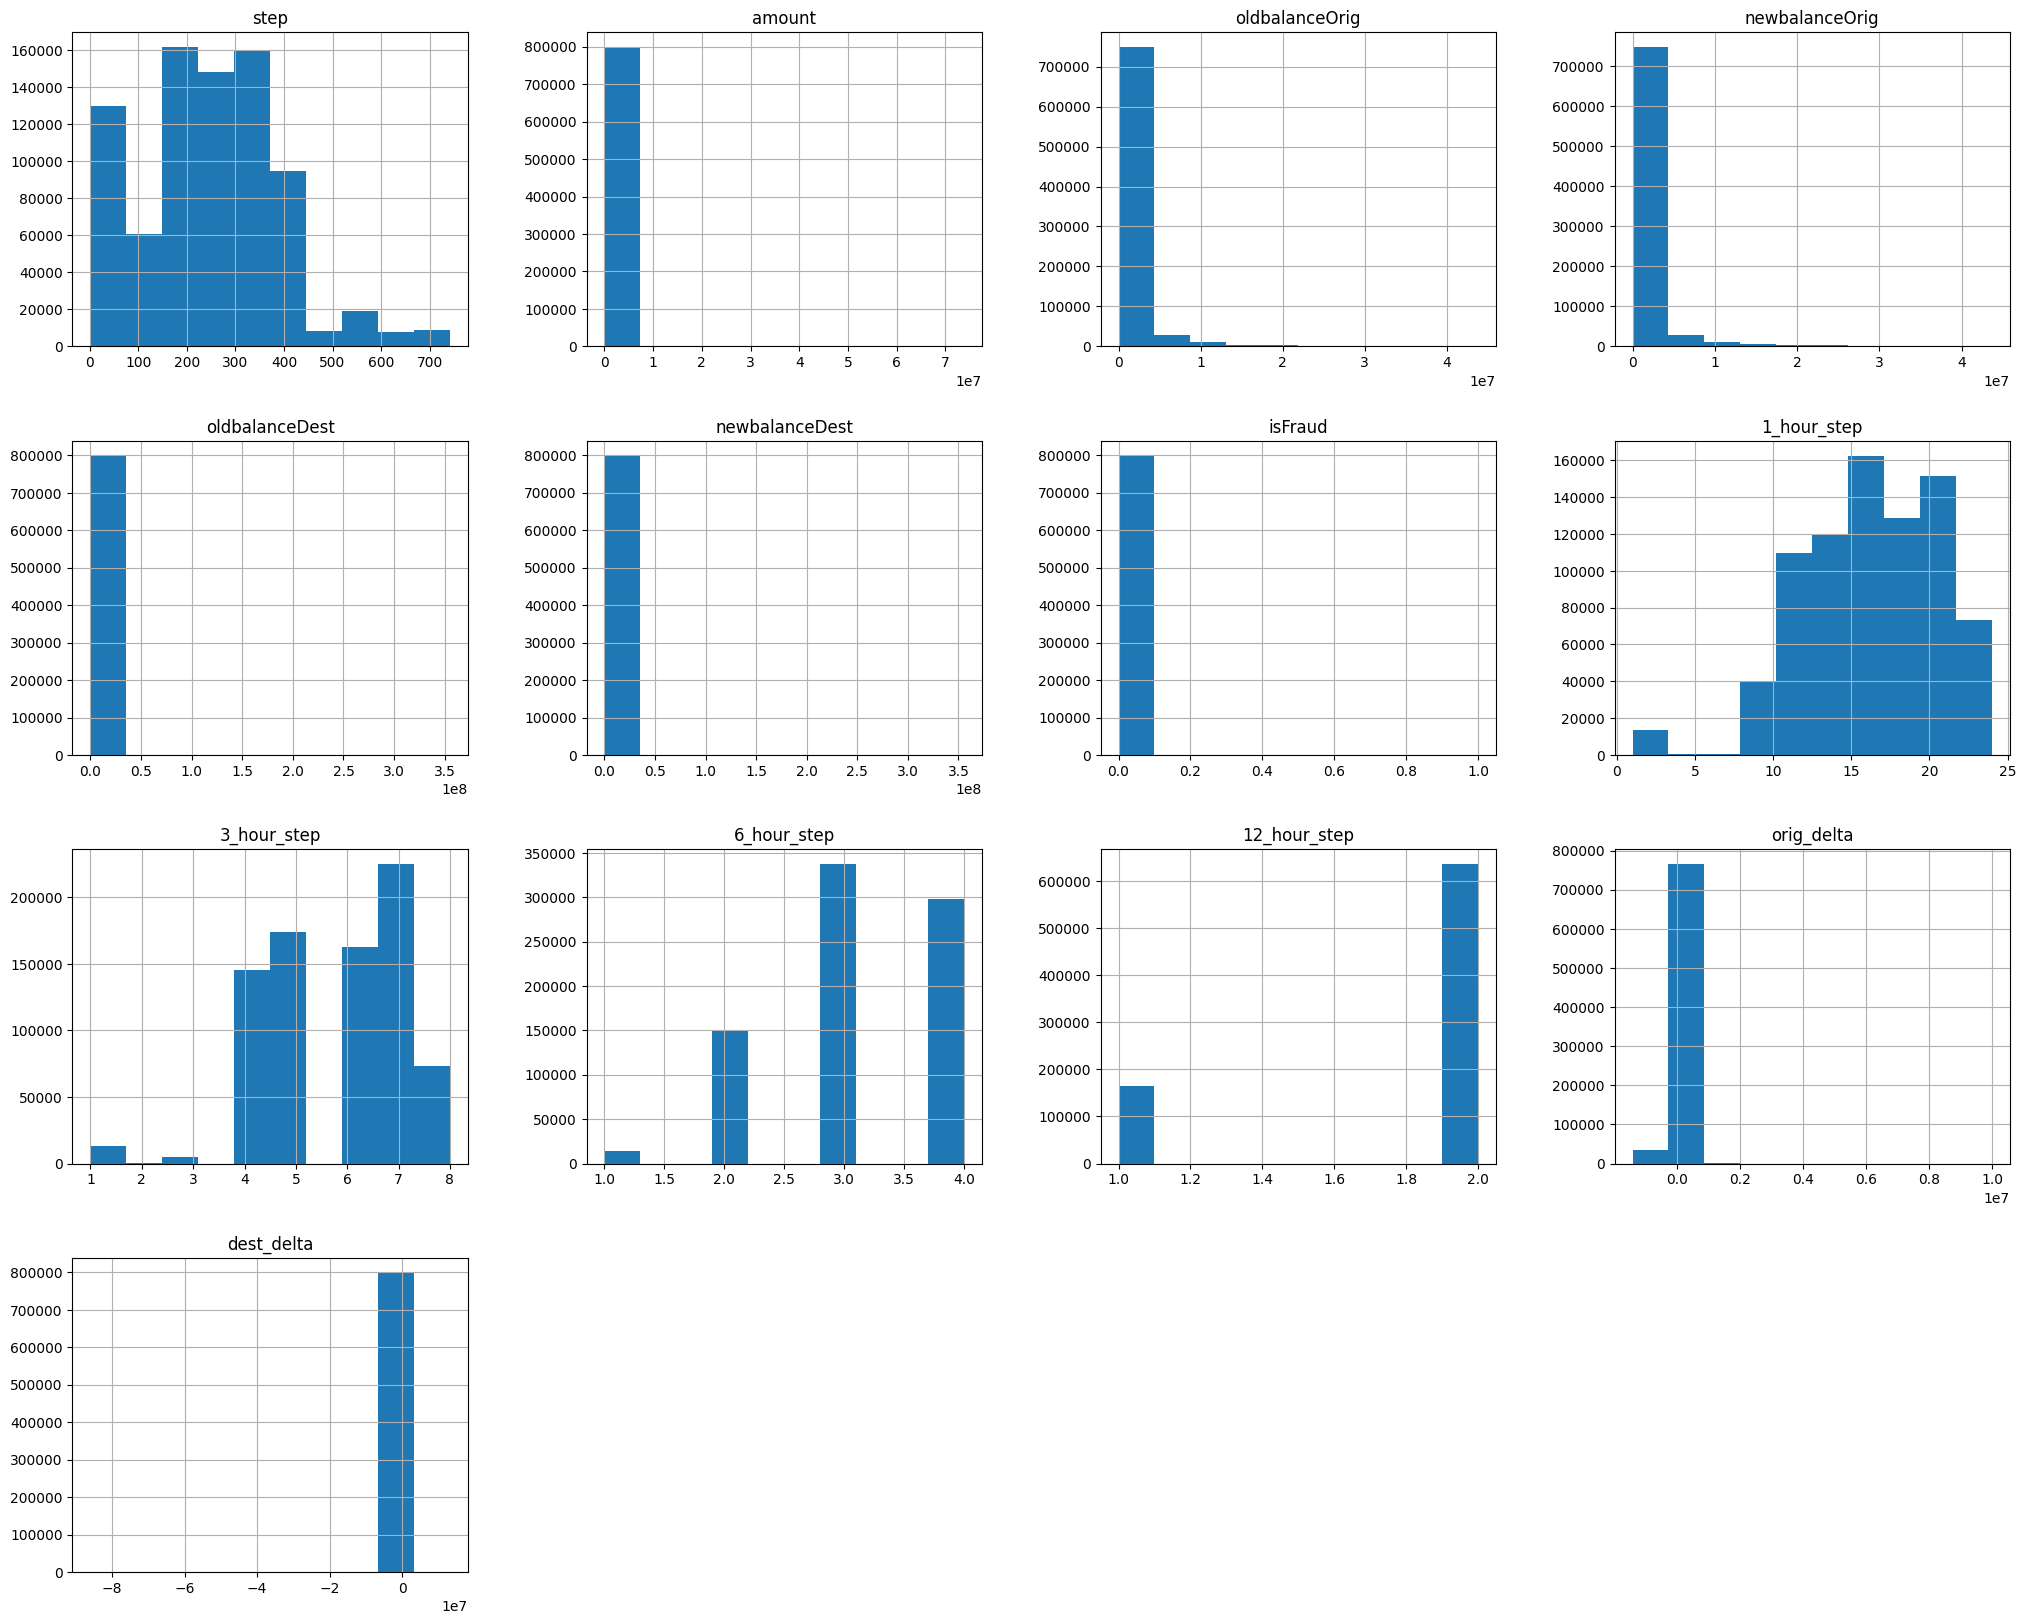

In [15]:
object_columns = df.select_dtypes(['object']).columns
num_columns = df.select_dtypes(['float64', 'int64']).columns
num_columns = num_columns.drop('isFraud')

## Numeric data
# Using in-built statistical summary
print(df.describe())

# Investigating target/class labels:
print(f"% of {len(df)} transactions that are fradulent: {np.mean(df.isFraud)*100:.3g}")
# It is clear that the fraudulent transactions are highly rare - we can assume here that a decision tree, given the probable low entropy of the 'isFraud' target,
# will be best predicted by a decision tree classifer due to its sparse nature.

# Plot histograms for numeric data
df.hist(bins=10, figsize=(25, 20))


## Categorical Data
object_df = pd.DataFrame(columns=['Variable', 'Unique Values', 'Top 5 Categories', 'Top 5 %'])
for column in object_columns:
    nunique = df[column].nunique()
    top_5 = df[column].value_counts().nlargest(5)
    top_5_pct = df[column].value_counts(normalize=True).nlargest(5) * 100
    print(f"Details of {column}:")
    print(f"Unique Values: {nunique}")
    print(f"Top 5 Attribute Values by %:")
    print(top_5_pct)
    print("\n")
    # object_df = object_df._append({'Variable':column, 'Unique Values': nunique, 'Top 5 Category Counts':top_5, 'Top 5 %':top_5_pct}, ignore_index=True)

# From histograms, it is clear that key numeric variables like account balance and amount will need to be investigated further
# In the first experimentation, I'm attempting to split the numeric data into 2-4 buckets based on the
# sample distribution, so that each bucket has roughly the same number of amounts.




### Analysing Correlations between Variables


isFraud           1.000000
orig_delta        0.338203
amount            0.066013
step              0.031387
oldbalanceOrig    0.008386
newbalanceDest   -0.000614
oldbalanceDest   -0.006511
newbalanceOrig   -0.007957
dest_delta       -0.023689
12_hour_step     -0.025035
6_hour_step      -0.028126
1_hour_step      -0.029834
3_hour_step      -0.030480
Name: isFraud, dtype: float64


<Axes: >

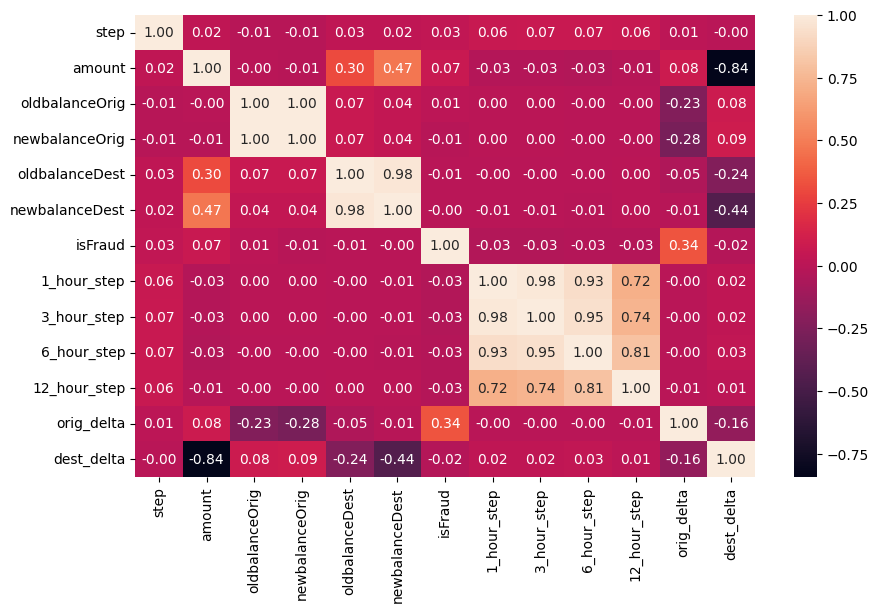

In [18]:
## For numeric variables
correlation = df.corr(numeric_only=True)
fraud_correlation = correlation['isFraud'].sort_values(ascending=False)
print(fraud_correlation)

## Using seaborn to visualize correlation matrix

plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True, fmt='.2f')

# A few interesting observations come out here:
# There's high correlation between new and old balance for the origin and destination accounts, respectively.
    # This is expected, considering if old balance is high, then it's likely the new balance is also high.
# The 3-hour step seems to possess the same amount of correlation with isFraud as the 'step' variable, in the opposite direction
# There is a surprisingly high correlation between origin account balance delta and the isFraud variable.


#### Exploring representation of target classes in each attribute

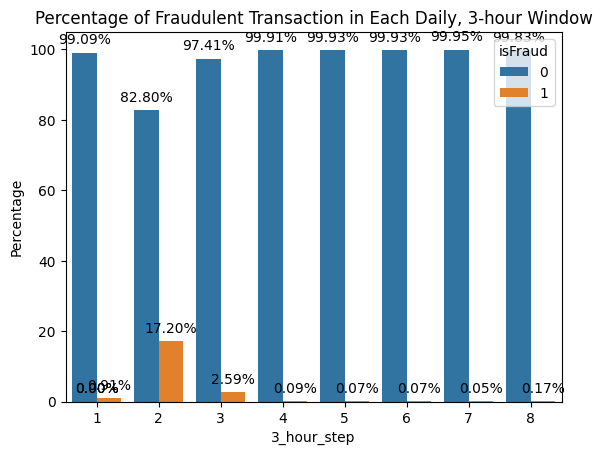

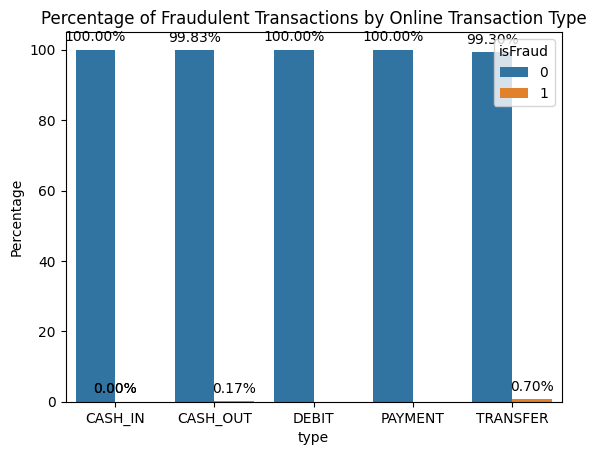

In [34]:
# Given the that this is a classification task, it becomes important to explore how each class
# is represented in the categorical variables. As I've converted the step into a categorical, and noticed
# a small yet interesting correlation between isFraud and the 3_hour_step, I wanted to explore the distributiion
# of isFraud across 3_hour_step to see what was driving the correlation.

# This is done below, by using percentages, since the absolute counts of isFraud occurrences are extremely low in absolute terms.

count_df = df.groupby(['3_hour_step', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['3_hour_step']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='3_hour_step')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='3_hour_step', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.title('Percentage of Fraudulent Transactions by Daily 3-hour Windows')
plt.show()

# Repeat visualization with 'type' attribute
count_df = df.groupby(['type', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['type']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='type')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='type', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')
plt.title('Percentage of Fraudulent Transactions by Online Transaction Type')
plt.show()



In [ ]:
## As additional exploration, before completely dropping the nameOrig and name

